<Body>   
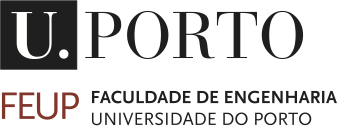   
<h1> <b>Swarm Robotics Competitions 2022/2023 </b> </h1>
</Body>  

**A. Pedro Aguiar** (pedro.aguiar@fe.up.pt)

FEUP, Oct. 2022

---


# **Identification**

**Group:** 1

* **Name:** João Coelho         **Student Number:** 202004846
* **Name:** João Mota           **Student Number:** 202108677
* **Name:** Marco Vilas Boas    **Student Number:** 202108774
* **Name:** Pedro Landolt       **Student Number:** 202103337


---





# Swarm Marathon Competition


**Goal:** Collect a set of resources at positions $R_i$, $i=1, \ldots M$, and drop them at the warehouse (green border in the plot) within a fixed period of time $T$.

**Specifications:**
-  The fleet is composed by 5 drones.
- Drone 1 is the leader and has access to its global position $x_1=[x_{1_1} x_{2_1}]$.
-  All the other drones *only* have access to the relative position $x_{ij}$ with respect to the other drones, if they are close enough to them (maximum range of MAX_RANGE).  
Example: Suppose that drone 1 and 3 are the only ones that are close to drone 2, then 
drone 2 has access to the relative position $x_{21}=x_2-x_1$ and $x_{23}=x_2-x_3$, while the others by convention take the value zero $x_{24}=x_{25}=0$. 
- All drones have access to the closest distance and angle (direction) of the nearest obstacle, that is, $d_{io}$ and $\theta_{io}$.
- The maximum linear velocities (input) in $x$ and $y$ directions is $1\,m/s$, that is, $-1\le u_x, u_y \le 1$.
- The resources can only be picked and transported with two drones. Moreover, when two drones are carrying a resource, they cannot carry a second resource, and they should be no more than MAX_R_DIS apart of each other, otherwise it is considered that the resource is lost. 
- The drones cannot collide with each other, walls, and obstacles. In case of collision, the drone that collided stop and you do not have access to it. If it was transporting a resource, the resource returns to its initial position.

**Scores:**
- The times of picking the resources and dropping in the warehouse are saved. If the drones lost the resource, the time will be reseted.

- Wins the one that returned the maximum number of resources at the warehouse in less time.

**Parameters of this scenario:**
- Range of communication to obtain the relative position: MAX_RANGE = $5\,m$
- Maximum distance between 2 drones that they can be to pick a resource: MAX_R_PICK = $1\,m$
- Maximum distance between 2 drones that they can be to transport a resource: MAX_R_DIS = $3\,m$
- Initial configuration of the drones: 5-4-1-2-3 with same position in $y=-8\,m$ and in $x$ of $-2\,m, -1\,m, 0\,m, 1\,m, 2\,m$, respectively.
---

**Initial setup:** To download the file **aux_file.py**, run the next cell (only once).

In [229]:
#!wget -O aux_file.py.zip https://www.dropbox.com/s/ahwox248sf5wgbk/aux_file.py.zip?dl=0 --quiet
#!unzip aux_file.py.zip -d. 




---
# **Scenario Task 3:** Two Resources $R_1$ and $R_2$ and two obstacles


$$
u_1 = - K_1 (x_1-x_d) + \frac{k_{1o}(d_1)}{d_1^2} ( x_1 - x_o ) + \dot{x}_d
$$
where
$$
k_{1o}(d) = \bar k_{1o}e^{-c d_1^2}, \quad d_1 = ||x_1 - x_o ||-r,
$$
$x_o$ and $r$ are the center position of the obstacle and radius, respectively, and $k_{1o}, c$ are positive gains.

However, in this scenario, two things happen:
- The resource is stationary, so we have
$$
\quad \dot x_d = 0
$$

- We don't know the center of the obstacle $x_o$, so we'll consider $x_o$ to be the closest point of the obstacle to the agent.

With this in mind, the control law for agent 1 (leader) simplifies to

---
$$
u_1 = - K (x_1-x_d) - \frac{k_{o}(d_{1o})}{(d_{1o}+\epsilon)} 
\left[
\begin{array}{c}
\cos\theta_{1o} \\
\sin\theta_{1o}
\end{array}
\right]
$$

---
with $\epsilon>0$ a small constant.

To make sure that the other agents follow the leader, don't collide with each other and avoid all obstacles, we set 

---
$$
u_i = - K \sum_{j\in N_i}\big(x_{ij} -b_{ij}\big) + \sum_{j= 1}^n \frac{k_{o}(d_{ij})}{(d_{ij}^2+\epsilon)}  x_{ij} - \sum_{o=1}^p\frac{k_{o}(d_{io})}{(d_{io}+\epsilon)}
\left[
\begin{array}{c}
\cos\theta_{io} \\
\sin\theta_{io}
\end{array}
\right], \quad i=2, 3,\ldots 5
$$

---
where $p$ is the number of objects, $x_{ij}$ is the relative position from drone $i$ to drone $j$, and $d_{ij} = ||x_{ij}||$ its distance, $K$ is a $2\times 2$ positive-definite matrix gain, and the bias terms $b_{ij}= -b_{ji}$ specifies the formation configuration.


In [230]:
Gnumber = 1  #Group number
verbose = 1

In [231]:
def my_swarm_control_law(t, R1, R2, R1_caught, R2_caught, R1_at_warehouse, R2_at_warehouse, \
                         d1o, angle1, d2o, angle2, d3o, angle3, d4o, angle4, d5o, angle5, \
                         state1, x12, x13, x14, x15, x21, x23, x24, x25, \
                         x31, x32, x34, x35, x41, x42, x43, x45, x51, x52, x53, x54):
###################################################################################################
##                                                                                               ##
## Grupo 1                                                                                       ##
## João Coelho          202004846                                                                ##
## João Mota            202108677                                                                ##
## Marco Vilas Boas     202108774                                                                ##
## Pedro Landolt        202103337                                                                ##
##                                                                                               ##
###################################################################################################
#
# Here goes the list of variables that you can use in this part: 
# time: t
# Resource positions: R1, R2
# Boolean variables that indicate if the Resource is with a pair of drones: R1_caught, R2_caught
# Boolean variables that indicate if the Resource was delivered at the warehouse: R1_at_warehouse, R2_at_warehouse
# distances and angles to the nearest obstacle: d1o, angle1, d2o, angle2, ...
# position of drone 1: state1
# relative positions: x12, x13, x14, x15, x21, x23, x24, x25, ...
# note that the relative positions are set to zero when its norm is bigger than MAX_RANGE

  # My parameters
  kx, ky = 4, 4
  K = np.diag([kx,ky])
  c = 1
  Ko_init = 0.2*K
  xd = (-9, -9)
  b12 = [0.5, 0.0]
  b23 = [0.5, 0.0]
  b14 = [0.5, 0.0]
  b45 = [0.5, 0.0]
  

  if not R1_caught and not R1_at_warehouse:
    resource_direction = (R1[0]-state1[0], R1[1]-state1[1])
    resource_direction = resource_direction/np.linalg.norm(resource_direction)
    b12 = 0.5*resource_direction
    b23 = 0.5*resource_direction
    b14 = 0.5*resource_direction
    b45 = 0.5*resource_direction
    xd =  (R1[0]+resource_direction[0]+2*b12[0], R1[1]+resource_direction[1]+2*b12[1])

  elif not R2_caught and not R2_at_warehouse:
    #print("I'm steering to R2")
    resource_direction = (R2[0]-R1[0], R2[1]-R1[1])
    resource_direction = resource_direction/np.linalg.norm(resource_direction)
    b12 = 0.5*resource_direction
    b23 = 0.5*resource_direction
    b14 = 0.5*resource_direction
    b45 = 0.5*resource_direction
    xd  = (R2[0]+resource_direction[0]+b14[0]+b23[0], R2[1]+resource_direction[1]+b14[1]+b23[1])
    
    
  # Drone 1 - Leader
  u_control1 = - 0.6*K @ (state1 - xd) \
    - (1/(d1o+.1))*10*Ko_init*np.exp(-c*d1o**2) @ ( np.cos(angle1), np.sin(angle1) ) \
    - (1/(d2o+.1))*10*Ko_init*np.exp(-c*d2o**2) @ ( np.cos(angle2), np.sin(angle2) ) \
    - (1/(d3o+.1))*10*Ko_init*np.exp(-c*d3o**2) @ ( np.cos(angle3), np.sin(angle3) ) \
    - (1/(d4o+.1))*10*Ko_init*np.exp(-c*d4o**2) @ ( np.cos(angle4), np.sin(angle4) ) \
    - (1/(d5o+.1))*10*Ko_init*np.exp(-c*d5o**2) @ ( np.cos(angle5), np.sin(angle5) )


  # Drone 2 
  u_control2 = - K @ ((x21+b12) + (x23-b23)) \
  + 1/(np.linalg.norm(x21)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x21)**2) @ x21 \
  + 1/(np.linalg.norm(x23)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x23)**2) @ x23 \
  + 1/(np.linalg.norm(x24)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x24)**2) @ x24 \
  + 1/(np.linalg.norm(x25)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x25)**2) @ x25 \
  - 1/(d1o+.1)*Ko_init*np.exp(-c*d1o**2) @ ( np.cos(angle1), np.sin(angle1) ) \
  - 1/(d2o+.1)*Ko_init*np.exp(-c*d2o**2) @ ( np.cos(angle2), np.sin(angle2) ) \
  - 1/(d3o+.1)*Ko_init*np.exp(-c*d3o**2) @ ( np.cos(angle3), np.sin(angle3) ) \
  - 1/(d4o+.1)*Ko_init*np.exp(-c*d4o**2) @ ( np.cos(angle4), np.sin(angle4) ) \
  - 1/(d5o+.1)*Ko_init*np.exp(-c*d5o**2) @ ( np.cos(angle5), np.sin(angle5) )

  # Drone 3
  u_control3 = - K @ (x32+b23) \
  + 1/(np.linalg.norm(x31)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x31)**2) @ x31 \
  + 1/(np.linalg.norm(x32)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x32)**2) @ x32 \
  + 1/(np.linalg.norm(x34)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x34)**2) @ x34 \
  + 1/(np.linalg.norm(x35)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x35)**2) @ x35 \
  - 1/(d1o+.1)*Ko_init*np.exp(-c*d1o**2) @ ( np.cos(angle1), np.sin(angle1) ) \
  - 1/(d2o+.1)*Ko_init*np.exp(-c*d2o**2) @ ( np.cos(angle2), np.sin(angle2) ) \
  - 1/(d3o+.1)*Ko_init*np.exp(-c*d3o**2) @ ( np.cos(angle3), np.sin(angle3) ) \
  - 1/(d4o+.1)*Ko_init*np.exp(-c*d4o**2) @ ( np.cos(angle4), np.sin(angle4) ) \
  - 1/(d5o+.1)*Ko_init*np.exp(-c*d5o**2) @ ( np.cos(angle5), np.sin(angle5) )

  # Drone 4
  u_control4 = - K @ ((x41+b14) + (x45-b45)) \
  + 1/(np.linalg.norm(x41)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x41)**2) @ x41 \
  + 1/(np.linalg.norm(x42)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x42)**2) @ x42 \
  + 1/(np.linalg.norm(x43)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x43)**2) @ x43 \
  + 1/(np.linalg.norm(x45)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x45)**2) @ x45 \
  - 1/(d1o+.1)*Ko_init*np.exp(-c*d1o**2) @ ( np.cos(angle1), np.sin(angle1) ) \
  - 1/(d2o+.1)*Ko_init*np.exp(-c*d2o**2) @ ( np.cos(angle2), np.sin(angle2) ) \
  - 1/(d3o+.1)*Ko_init*np.exp(-c*d3o**2) @ ( np.cos(angle3), np.sin(angle3) ) \
  - 1/(d4o+.1)*Ko_init*np.exp(-c*d4o**2) @ ( np.cos(angle4), np.sin(angle4) ) \
  - 1/(d5o+.1)*Ko_init*np.exp(-c*d5o**2) @ ( np.cos(angle5), np.sin(angle5) )
 
  # Drone 5
  u_control5 = - K @ (x54+b45) \
  + 1/(np.linalg.norm(x51)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x51)**2) @ x51 \
  + 1/(np.linalg.norm(x52)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x52)**2) @ x52 \
  + 1/(np.linalg.norm(x53)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x53)**2) @ x53 \
  + 1/(np.linalg.norm(x54)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x54)**2) @ x54 \
  - 1/(d1o+.1)*Ko_init*np.exp(-c*d1o**2) @ ( np.cos(angle1), np.sin(angle1) ) \
  - 1/(d2o+.1)*Ko_init*np.exp(-c*d2o**2) @ ( np.cos(angle2), np.sin(angle2) ) \
  - 1/(d3o+.1)*Ko_init*np.exp(-c*d3o**2) @ ( np.cos(angle3), np.sin(angle3) ) \
  - 1/(d4o+.1)*Ko_init*np.exp(-c*d4o**2) @ ( np.cos(angle4), np.sin(angle4) ) \
  - 1/(d5o+.1)*Ko_init*np.exp(-c*d5o**2) @ ( np.cos(angle5), np.sin(angle5) )

  return u_control1, u_control2, u_control3, u_control4, u_control5
###################################################################################################
##                                                                                               ##
##                              End of your code section, do not edit the next part              ##
##                                                                                               ##
###################################################################################################

In [232]:
#verbose = 1  #set to zero for no verbose
#verbose = 0  #set to zero for no verbose

import math
import numpy as np
import copy
#from aux_file import Integrator, Line, Ellipse, World, ConvexPolygon, check_collisions, update_relat_position, proximity, closest_drones, R_warehouse_check
from aux_file import Line, Ellipse, World, ConvexPolygon, check_collisions, update_relat_position, proximity, closest_drones, R_warehouse_check


def step_f(x,u,h):
  return x + u*h


# Parameters of range
MAX_RANGE = 5
MAX_R_PICK = 1
MAX_R_DIS = 3

# World arena
arena = ConvexPolygon([[ 10.0, -10.0 ],
                       [ 10.0, 10.0 ],
                       [ -10.0, 10.0 ],
                       [ -10.0, -10.0]])

# World obstacles
obs1 = Ellipse(center = [7.0, 0.0], angle = np.radians(-15.0), axes = [3.0, 1.5])
obs2 = Ellipse(center = [-2.5, 5.0], angle = np.radians(0.0), axes = [2.5, 2.5])

# Resource
initial_resource = {1: [7.5,5], 2: [-7.5,7.5]}
resource = copy.deepcopy(initial_resource)
num_R = 2
R1_caught = False
R2_caught = False

# Define world
world = World(arena)
world.add_obstacle(obs1)
world.add_obstacle(obs2)


# Time of simulation
sim_time = 60
dt = 0.02

t_signal = np.arange(0,sim_time,dt) # time samples

x1_signal = np.zeros_like([t_signal,t_signal])
u1_signal = np.zeros_like([t_signal,t_signal])
x2_signal = np.zeros_like([t_signal,t_signal])
u2_signal = np.zeros_like([t_signal,t_signal])
x3_signal = np.zeros_like([t_signal,t_signal])
u3_signal = np.zeros_like([t_signal,t_signal])
x4_signal = np.zeros_like([t_signal,t_signal])
u4_signal = np.zeros_like([t_signal,t_signal])
x5_signal = np.zeros_like([t_signal,t_signal])
u5_signal = np.zeros_like([t_signal,t_signal])

#Initial conditions of each drone
x1_signal[:,0] = [2.0, -9.0]
x2_signal[:,0] = [1.0, -9.0]
x3_signal[:,0] = [0.0, -9.0]
x4_signal[:,0] = [-1.0, -9.0]
x5_signal[:,0] = [-2.0, -9.0]

#Closest point
cpx1, cpy1, cpx2, cpy2, cpx3, cpy3, cpx4, cpy4, cpx5, cpy5 = [], [], [], [], [], [], [], [], [], []

# Configuration Matrices 
do = np.zeros((5)) # Distance to obstacle
d_mtx = np.zeros((5)) # Damaged matrix
R_delivered = np.zeros((2)) # Indicates if Resource was delivered at the warehouse
w_R_mtx = np.zeros((5)) # Matrix that tells if a pair of drones caught some R
time_score = np.array([999.9,999.9,999.9,999.9]) # 0 - caught R_1, 1 - caught R_2, 2 - drop R_1 in warehouse, 3 - drop R_2 in warehouse
position_mtx = np.zeros((5,5)) # matrix that indicates which drones are near


# Here goes the main loop
for i in range(0,t_signal.shape[0]-1):

  if t_signal[i]%5 == 0:
    print("Time: t =", t_signal[i])
  # Get the state
  x1 = x1_signal[:,i]
  x2 = x2_signal[:,i]
  x3 = x3_signal[:,i]
  x4 = x4_signal[:,i]
  x5 = x5_signal[:,i]
    
  # Relative positions
  x12, x13, x14, x15 = x1 - x2, x1 - x3, x1 - x4, x1 - x5
  x21, x23, x24, x25 = x2 - x1, x2 - x3, x2 - x4, x2 - x5
  x31, x32, x34, x35 = x3 - x1, x3 - x2, x3 - x4, x3 - x5
  x41, x42, x43, x45 = x4 - x1, x4 - x2, x4 - x3, x4 - x5
  x51, x52, x53, x54 = x5 - x1, x5 - x2, x5 - x3, x5 - x4
  x_all = (x21, x23, x24, x25, x31, x32, x34, x35, x41, x42, x43, x45, x51, x52, x53, x54, x12, x13, x14, x15)
  position_mtx, xi_all = update_relat_position(position_mtx, x_all, MAX_RANGE)
  x21, x23, x24, x25, x31, x32, x34, x35, x41, x42, x43, x45, x51, x52, x53, x54, x12, x13, x14, x15 = x_all[0], x_all[1], x_all[2], x_all[3], x_all[4], x_all[5], x_all[6], x_all[7], x_all[8], x_all[9], x_all[10], x_all[11], x_all[12], x_all[13], x_all[14], x_all[15], x_all[16], x_all[17], x_all[18], x_all[19]
 
  # Get the closest point of obstacles of each drone
  closest_pt, do[0] = world.compute_closest(x1) 
  d1o = do[0]
  angle1 = np.arctan2(closest_pt[1]-x1[1],closest_pt[0]-x1[0])
  cpx1.append(closest_pt[0])
  cpy1.append(closest_pt[1])
  
  closest_pt, do[1] = world.compute_closest(x2) 
  d2o = do[1]
  angle2 = np.arctan2(closest_pt[1]-x2[1],closest_pt[0]-x2[0])
  cpx2.append(closest_pt[0])
  cpy2.append(closest_pt[1])
  
  closest_pt, do[2] = world.compute_closest(x3) 
  d3o = do[2]
  angle3 = np.arctan2(closest_pt[1]-x3[1],closest_pt[0]-x3[0])
  cpx3.append(closest_pt[0])
  cpy3.append(closest_pt[1])

  closest_pt, do[3] = world.compute_closest(x4) # closest point and distance to that point
  d4o = do[3]
  angle4 = np.arctan2(closest_pt[1]-x4[1],closest_pt[0]-x4[0])
  cpx4.append(closest_pt[0])
  cpy4.append(closest_pt[1])

  closest_pt, do[4] = world.compute_closest(x5) # closest point and distance to that point
  d5o = do[4]
  angle5 = np.arctan2(closest_pt[1]-x5[1],closest_pt[0]-x5[0])
  cpx5.append(closest_pt[0])
  cpy5.append(closest_pt[1])

  #Resources positions
  R1=resource[1]
  R2=resource[2]

  R1_at_warehouse = R_delivered[0]
  R2_at_warehouse = R_delivered[1]

  ######## Calling the control law for each drone
  u_control1, u_control2, u_control3, u_control4, u_control5 = my_swarm_control_law(t_signal[i], R1, R2, R1_caught, R2_caught, R1_at_warehouse, R2_at_warehouse, \
                                                                                    d1o, angle1, d2o, angle2, d3o, angle3, d4o, angle4, d5o, angle5, \
                                                                                    x1, x12, x13, x14, x15, x21, x23, x24, x25, \
                                                                                    x31, x32, x34, x35, x41, x42, x43, x45, x51, x52, x53, x54)
  ########

  xi = (x21, x31, x41, x51)
  points_vec = np.array([x1,x2,x3,x4,x5])

  # Check collisions
  d_mtx, w_R_mtx, time_score = check_collisions(points_vec, d_mtx, w_R_mtx, do, xi, time_score)
  
  # compute a proximity table to check what are the drones that are closer to the Resources
  prox_mtx_1, prox_mtx_2 = proximity(points_vec, resource, num_R)

  # Send actuation commands
  if d_mtx[0]==1:
      u_control1=[0,0]
      prox_mtx_1[0] = 99
      prox_mtx_2[0] = 99    

  if d_mtx[1]==1:
      u_control2=[0,0]
      prox_mtx_1[1] = 99
      prox_mtx_2[1] = 99

  if d_mtx[2]==1:
      u_control3=[0,0]
      prox_mtx_1[2] = 99
      prox_mtx_2[2] = 99

  if d_mtx[3]==1:
      u_control4=[0,0]
      prox_mtx_1[3] = 99
      prox_mtx_2[3] = 99

  if d_mtx[4]==1:
      u_control5=[0,0]
      prox_mtx_1[4] = 99
      prox_mtx_2[4] = 99
  
  # Find the closest drones to the Resource
#  w_R_mtx, time_score = closest_drones(prox_mtx_1, prox_mtx_2, w_R_mtx, time_score, t, R_delivered, num_R, MAX_R_PICK)
  w_R_mtx, time_score = closest_drones(prox_mtx_1, prox_mtx_2, w_R_mtx, time_score, t_signal[i], R_delivered, num_R, MAX_R_PICK,verbose)

  if 1 in w_R_mtx:
      R1_caught = True
  else:
      R1_caught = False
  
  if 2 in w_R_mtx:
      R2_caught = True
  else:
      R2_caught = False
  
  # Saturate the control inputs between -1 and 1 
  u1_signal[:,i] = np.clip(u_control1, -1, 1)
  u2_signal[:,i] = np.clip(u_control2, -1, 1)
  u3_signal[:,i] = np.clip(u_control3, -1, 1)
  u4_signal[:,i] = np.clip(u_control4, -1, 1)
  u5_signal[:,i] = np.clip(u_control5, -1, 1)

  # update/send the actuation signals
  x1_signal[:,i+1] = step_f(x1_signal[:,i],u1_signal[:,i],dt)
  x2_signal[:,i+1] = step_f(x2_signal[:,i],u2_signal[:,i],dt)
  x3_signal[:,i+1] = step_f(x3_signal[:,i],u3_signal[:,i],dt)
  x4_signal[:,i+1] = step_f(x4_signal[:,i],u4_signal[:,i],dt)
  x5_signal[:,i+1] = step_f(x5_signal[:,i],u5_signal[:,i],dt)

  
  w_R_mtx, time_score, R_delivered = R_warehouse_check(w_R_mtx, points_vec, resource, time_score, t_signal[i], R_delivered, MAX_R_DIS)
   

Time: t = 0.0


/home/marco-vb/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/marco-vb/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Time: t = 5.0
Time: t = 10.0
Time: t = 15.0
Drone 1 found the Resource 1 at time t= 15.74
But no other drone found the Resource 1...
Drone 1 found the Resource 1 at time t= 15.76
But no other drone found the Resource 1...
Drone 1 found the Resource 1 at time t= 15.780000000000001
But no other drone found the Resource 1...
Drone 1 found the Resource 1 at time t= 15.8
But no other drone found the Resource 1...
Drone 1 found the Resource 1 at time t= 15.82
But no other drone found the Resource 1...
Drone 1 found the Resource 1 at time t= 15.84
But no other drone found the Resource 1...
Drone 1 found the Resource 1 at time t= 15.860000000000001
But no other drone found the Resource 1...
Drone 1 found the Resource 1 at time t= 15.88
But no other drone found the Resource 1...
Drone 1 found the Resource 1 at time t= 15.9
But no other drone found the Resource 1...
Drone 1 found the Resource 1 at time t= 15.92
But no other drone found the Resource 1...
Drone 1 found the Resource 1 at time t= 15

Results:
Time of picking Resource 1: 17.0
Time of picking resource 2: 33.02
Time of delivering Resource 1 at the warehouse: 46.78
Time of delivering Resource 2 at the warehouse: 46.44
Final score: 46.78


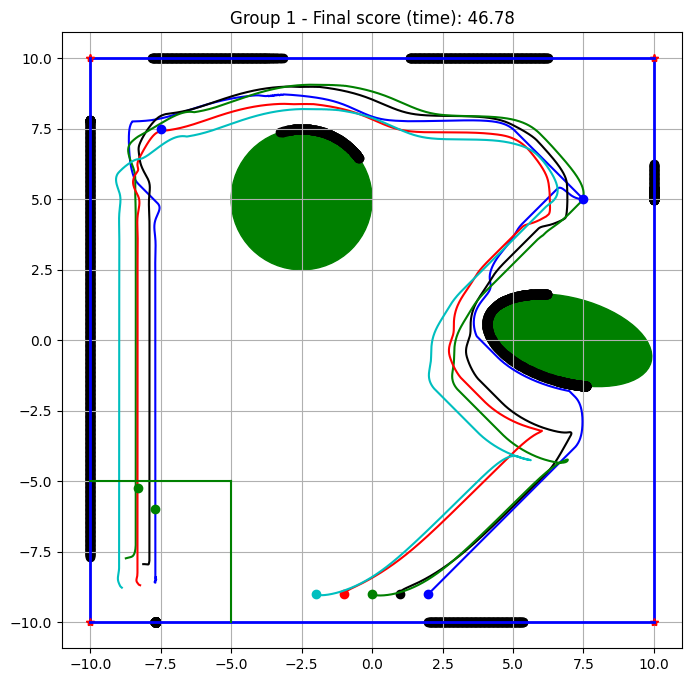

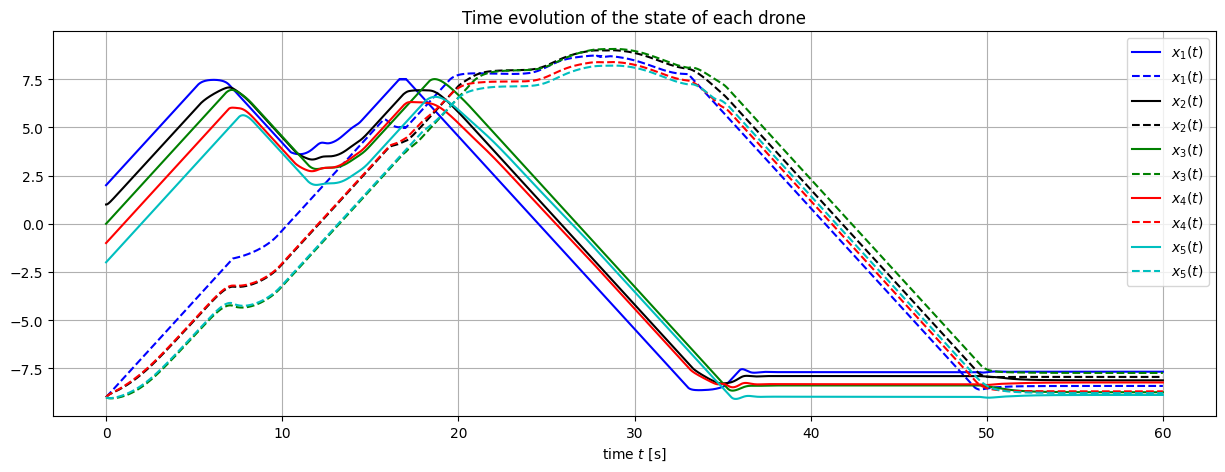

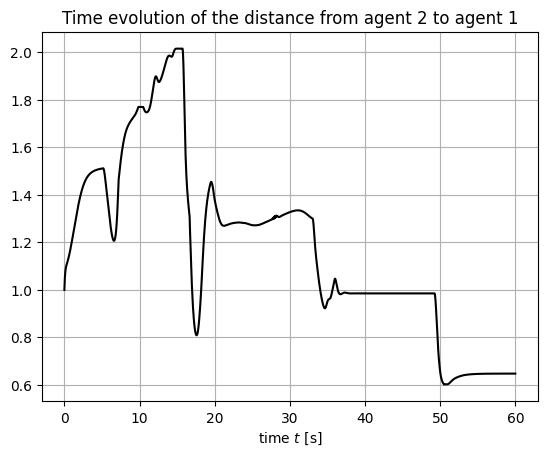

In [233]:
# Plot commands
%matplotlib inline 
#%matplotlib notebook

import matplotlib.pyplot as plt

#fig, ax = plt.subplots(figsize=(18,18))
fig, ax = plt.subplots(figsize=(8,8))

#plt.figure(figsize=(1,1))
ax.axis('equal')
xdim, ydim = 10, 10
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.grid()

# Plots walls and obstacles
world.plot()

pt1, = plt.plot([], [], 'b.', ms=20)
pt2, = plt.plot([], [], 'k.', ms=20)
pt3, = plt.plot([], [], 'g.', ms=20)
pt4, = plt.plot([], [], 'r.', ms=20)
pt5, = plt.plot([], [], 'c.', ms=20)
plt.plot(x1_signal[0][0], x1_signal[1][0], marker='o', color='b')
plt.plot(x2_signal[0][0], x2_signal[1][0], marker='o', color='k')
plt.plot(x3_signal[0][0], x3_signal[1][0], marker='o', color='g')
plt.plot(x4_signal[0][0], x4_signal[1][0], marker='o', color='r')
plt.plot(x5_signal[0][0], x5_signal[1][0], marker='o', color='c')


line1, = plt.plot(x1_signal[0], x1_signal[1], label='$x_1(t)$', color='b')
points_lidar = plt.scatter(cpx1, cpy1, label='$cpx_1(t)$', marker='o', color='k')
line2, = plt.plot(x2_signal[0], x2_signal[1], label='$x_2(t)$', color='k')
line3, = plt.plot(x3_signal[0], x3_signal[1], label='$x_3(t)$', color='g')
line4, = plt.plot(x4_signal[0], x4_signal[1], label='$x_4(t)$', color='r')
line5, = plt.plot(x5_signal[0], x5_signal[1], label='$x_5(t)$', color='c')
plt.plot((-10,-5),(-5,-5), color='g')
plt.plot((-5,-5),(-5,-10), color='g')
plt.title('Group ' +str(Gnumber) + ' - Final score (time): '+ str(max(time_score[2],time_score[3])));


if R_delivered[0] == False:
    initial_resource1, = plt.plot(initial_resource[1][0], initial_resource[1][1], marker='o', color='r')
else:
    initial_resource1, = plt.plot(initial_resource[1][0], initial_resource[1][1], marker='o', color='b')
    final_resource1, = plt.plot(resource[1][0], resource[1][1], marker='o', color='g')

if num_R == 2:
    if R_delivered[1] == False:
        initial_resource2, = plt.plot(initial_resource[2][0], initial_resource[2][1], marker='o', color='r')
    else:
        initial_resource2, = plt.plot(initial_resource[2][0], initial_resource[2][1], marker='o', color='b')
        final_resource2, = plt.plot(resource[2][0], resource[2][1], marker='o', color='g')


# if d_mtx[0] == 1:
#     plt.plot(state1[0], state1[1], marker='*', color='y')
# if d_mtx[1] == 1:
#     plt.plot(state2[0], state2[1], marker='*', color='y')
# if d_mtx[2] == 1:
#     plt.plot(state3[0], state3[1], marker='*', color='y')
# if d_mtx[3] == 1:
#     plt.plot(state4[0], state4[1], marker='*', color='y')
# if d_mtx[4] == 1:
#     plt.plot(state5[0], state5[1], marker='*', color='y')


plt.figure(figsize=(15,5))
plt.plot(t_signal, x1_signal[0], label='$x_1(t)$', color='b')
plt.plot(t_signal, x1_signal[1], label='$x_1(t)$', color='b', linestyle='dashed')
plt.plot(t_signal, x2_signal[0], label='$x_2(t)$', color='k')
plt.plot(t_signal, x2_signal[1], label='$x_2(t)$', color='k', linestyle='dashed')
plt.plot(t_signal, x3_signal[0], label='$x_3(t)$', color='g')
plt.plot(t_signal, x3_signal[1], label='$x_3(t)$', color='g', linestyle='dashed')
plt.plot(t_signal, x4_signal[0], label='$x_4(t)$', color='r')
plt.plot(t_signal, x4_signal[1], label='$x_4(t)$', color='r', linestyle='dashed')
plt.plot(t_signal, x5_signal[0], label='$x_5(t)$', color='c')
plt.plot(t_signal, x5_signal[1], label='$x_5(t)$', color='c', linestyle='dashed')
plt.xlabel('time $t$ [s]');
plt.legend(loc='best')
plt.grid()
plt.title('Time evolution of the state of each drone');



plt.figure()
x1=x1_signal[0]
y1=x1_signal[1]
x2=x2_signal[0]
y2=x2_signal[1]
xi21=zip(x1,y1,x2,y2)
xi21 = [np.sqrt((x1-x2)**2+(y1-y2)**2) for (x1,y1,x2,y2) in xi21]
plt.plot(t_signal, xi21, label='$x_1-x_2$', color='k')
plt.grid()
plt.title('Time evolution of the distance from agent 2 to agent 1');
plt.xlabel('time $t$ [s]');


print("Results:")
#time_score: 0 - caught R_1, 1 - caught R_2, 2 - drop R_1 in warehouse, 3 - drop R_2 in warehouse
print('Time of picking Resource 1:',time_score[0])
print('Time of picking resource 2:',time_score[1])
print('Time of delivering Resource 1 at the warehouse:',time_score[2])
print('Time of delivering Resource 2 at the warehouse:',time_score[3])
print('Final score:',max(time_score[2],time_score[3]))



In [234]:
from matplotlib import animation

x1=x1_signal[0]
y1=x1_signal[1]
x2=x2_signal[0]
y2=x2_signal[1]
x3=x3_signal[0]
y3=x3_signal[1]
x4=x4_signal[0]
y4=x4_signal[1]
x5=x5_signal[0]
y5=x5_signal[1]


fnum = len(x1)
#print(fnum)
# animation function. This is called sequentially
def drawframe(n):
  size_x = len(x1)
  frames = 100
  t_win = int(size_x/frames*(n+1)-1)
  if time_score[2]!=999.9:
      if t_signal[t_win] < time_score[0]:
          initial_resource1.set_data(initial_resource[1][0], initial_resource[1][1])
          initial_resource1.set_color('r')
      else: 
          initial_resource1.set_color('b')
  if time_score[2]!=999.9:
      if t_signal[t_win] < time_score[1]:
          initial_resource2.set_data(initial_resource[2][0], initial_resource[2][1])
          initial_resource2.set_color('r')
      else: 
          initial_resource2.set_color('b')
  
  if time_score[2]!=999.9:
      if t_signal[t_win] < time_score[2]:
          final_resource1.set_data(resource[1][0], resource[1][1])
          final_resource1.set_color("w")
          final_resource1.set_alpha(0.0)
      else:
          final_resource1.set_data(resource[1][0], resource[1][1])
          final_resource1.set_color("g")
          final_resource1.set_alpha(1.0)
  
  if time_score[2]!=999.9:
      if t_signal[t_win] < time_score[3]:
          final_resource2.set_data(resource[2][0], resource[2][1])
          final_resource2.set_color("w")
          final_resource2.set_alpha(0.0)
      else:
          final_resource2.set_data(resource[2][0], resource[2][1])
          final_resource2.set_color("g")
          final_resource2.set_alpha(1.0)

  pt1.set_data(x1_signal[0, t_win],x1_signal[1, t_win])  
  pt2.set_data(x2_signal[0, t_win],x2_signal[1, t_win])  
  pt3.set_data(x3_signal[0, t_win],x3_signal[1, t_win])  
  pt4.set_data(x4_signal[0, t_win],x4_signal[1, t_win])  
  pt5.set_data(x5_signal[0, t_win],x5_signal[1, t_win])  

  line1.set_data(x1[0:t_win], y1[0:t_win])
  line2.set_data(x2[0:t_win], y2[0:t_win])
  line3.set_data(x3[0:t_win], y3[0:t_win])
  line4.set_data(x4[0:t_win], y4[0:t_win])
  line5.set_data(x5[0:t_win], y5[0:t_win])
  points_lidar.set_offsets(np.c_[cpx1[0:t_win], cpy1[0:t_win]])
  return (line1,line2)


# blit=True re-draws only the parts that have changed.
#anim = animation.FuncAnimation(fig, drawframe, frames=fnum, interval=1000, blit=True)
anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=50, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())